In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, KFold
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

In [2]:
numeric_df = pd.read_csv("../data/items_processed.csv")
numeric_df.head()

,num_images,mileage,price,date_idx,app,art,atq,avo,bab,bfd,...,tag,tix,tld,tls,trb,tro,vgm,wan,wtd,wto
0,1,0.0,5.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,4.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.0,7.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.0,3.0,3,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0.0,5.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
with open("../data/reduced_features.npy", "rb") as image_npy:
    image_features = np.load(image_npy)

In [4]:
with open("../data/text_embeds.npy", "rb") as text_npy:
    text_features = np.load(text_npy)

In [5]:
assert text_features.shape[0] == numeric_df.shape[0]
assert image_features.shape[0] == numeric_df.shape[0]

In [6]:
target = numeric_df["price"].values

In [7]:
numeric_values = numeric_df.drop("price", axis = 1).values

In [8]:
numeric_features = numeric_df.drop("price", axis = 1).columns

In [9]:
numeric_values.shape, text_features.shape, image_features.shape

((3253, 62), (3253, 96), (3253, 210))

In [10]:
all_features = np.concatenate([numeric_values, text_features, image_features], axis = 1)
all_features.shape

(3253, 368)

In [11]:
# Remove Outliers in Modeling

pct_90 = np.percentile(target, 90)
pct_10 = np.percentile(target, 10)

print(pct_10, pct_90)

mask = (pct_10 <= target) & (target <= pct_90)

all_features = all_features[mask]
target = target[mask]

10.0 1740.000000000009


In [12]:
all_features.shape

(2698, 368)

In [13]:
### Linear Regression Analysis

In [14]:
def CV_train_regression(X, y, cv = 5):
    reg = LinearRegression()
    cv_results = cross_validate(reg,
                                X,
                                y,
                                cv = KFold(
                                    n_splits = 5, 
                                    shuffle = True,
                                    random_state = 0),
                                scoring = ["neg_root_mean_squared_error", "r2"],
                                return_estimator = True)
        
    return cv_results

In [15]:
linreg_cv = CV_train_regression(all_features, target)

In [16]:
linreg_cv

{'fit_time': array([0.39907718, 0.45181394, 0.44868612, 0.44932723, 0.46959829]),
 'score_time': array([0.00474286, 0.00864506, 0.00485086, 0.00341582, 0.00613189]),
 'estimator': [LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression()],
 'test_neg_root_mean_squared_error': array([-256.99057049, -262.70262202, -271.00317985, -600.06886142,
        -227.60428378]),
 'test_r2': array([ 0.1254323 ,  0.03836355,  0.08020644, -3.65623269,  0.15859087])}

In [17]:
print(f"Median RMSE: {-np.median(linreg_cv['test_neg_root_mean_squared_error'])}")
print(f"Median R2: {np.median(linreg_cv['test_r2'])}")

Median RMSE: 262.7026220163888
Median R2: 0.08020643780116865


In [18]:
X_train, X_test, y_train, y_test = train_test_split(all_features, target, train_size = 0.8, shuffle = True)

print((X_train.shape, X_test.shape, y_train.shape, y_test.shape))

((2158, 368), (540, 368), (2158,), (540,))


In [19]:
y_pred = linreg_cv["estimator"][-1].predict(X_test)

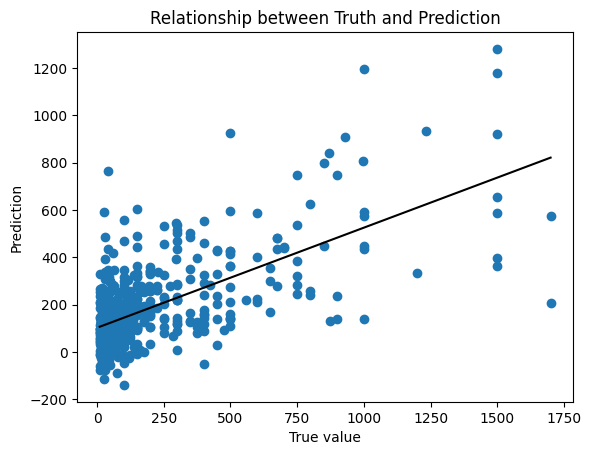

In [20]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), c = "black")
plt.xlabel("True value")
plt.ylabel("Prediction")
plt.title("Relationship between Truth and Prediction")
pass

In [21]:
def label_coef(c, i):
    numeric_values.shape, text_features.shape, image_features.shape
    if i < numeric_values.shape[1]:
        return ("scraped feature", c, i, numeric_features[i])
    
    if numeric_values.shape[1] <= i < (text_features.shape[1] + numeric_values.shape[1]):
        return ("text feature", c, i, None)
    
    if i >= (text_features.shape[1] + numeric_values.shape[1]):
        return ("image feature", c, i, None)

In [22]:
coef_df = pd.DataFrame(sorted(
    [label_coef(c, i) for i, c in enumerate(abs(linreg_cv["estimator"][2].coef_))],
    key = lambda x : x[1],
    reverse = True),
    columns = ["feature source", "coef", "feature index", "feature name"])

In [23]:
coef_df = coef_df.reset_index().rename({"index": "order"}, axis = 1)

In [24]:
coef_df

,order,feature source,coef,feature index,feature name
0,0,image feature,4.926121e+03,239,None
1,1,scraped feature,2.298969e+03,17,ctd
2,2,image feature,2.127794e+03,349,None
3,3,image feature,1.975369e+03,365,None
4,4,scraped feature,1.765744e+03,18,cto
...,...,...,...,...,...
363,363,scraped feature,6.989893e-10,46,rvs
364,364,scraped feature,6.065761e-10,36,mcy
365,365,scraped feature,5.366729e-10,29,hvd
366,366,scraped feature,3.019807e-10,54,tld


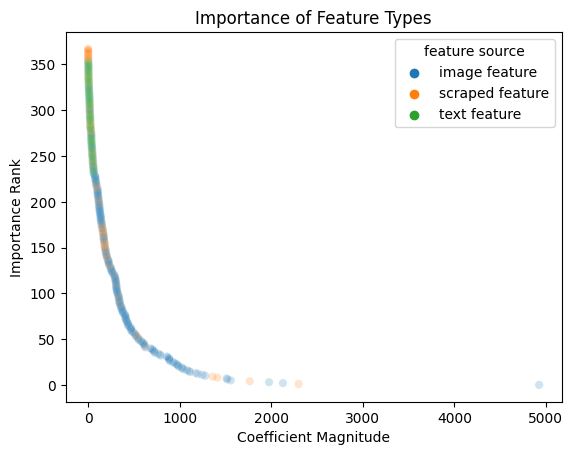

In [25]:
import seaborn as sns

sns.scatterplot(data = coef_df, x = "coef", y = "order", hue = "feature source", alpha = 0.2)
plt.title("Importance of Feature Types")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Importance Rank")
plt.savefig("../analysis_deliverable/visualizations/feature_importance.png")
pass
# coef_df[["order", "coef", "feature source"]].plot.scatter(x = "coef", y = "order", hue = "feature source")

In [26]:
### K-Means Clustering Analysis

In [27]:
def train_cluster(X, y, n_clusters = 10):
    kmeans = KMeans(n_clusters, random_state = 0)
    cluster_labels = kmeans.fit_predict(X)
    clusters = kmeans.cluster_centers_
    cluster_info = []
    for i in range(n_clusters):
        avg_cluster_price = np.mean(y[cluster_labels == i])
        num_values = sum(cluster_labels == i)
        cluster_info.append([avg_cluster_price, num_values])
    return pd.DataFrame(cluster_info, columns = ["average price in cluster", "num items in cluster"]), clusters, cluster_labels


In [28]:
cluster_df, cluster_centers, cluster_labels = train_cluster(all_features, target, 10)

In [29]:
cluster_price_df = pd.DataFrame(data = [cluster_labels, target], index = ["Cluster Label", "Price"]).T

Text(0.5, 1.0, 'Price Distribution in KMeans Clusters (All Features)')

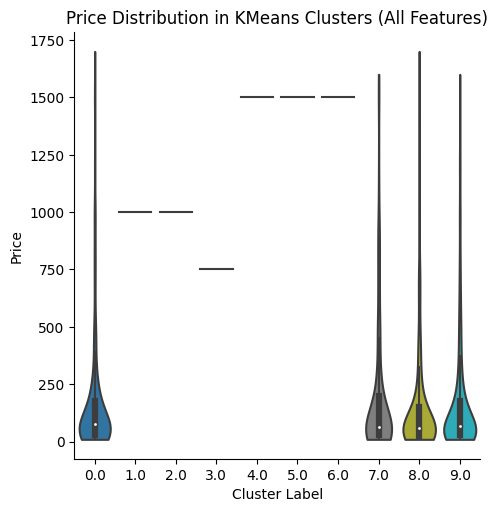

In [30]:
import seaborn as sns

sns.catplot(data = cluster_price_df, y="Price", x="Cluster Label",
    kind="violin", bw_adjust=.5, cut=0, split=True,)
plt.title("Price Distribution in KMeans Clusters (All Features)")

Text(0.5, 1.0, 'Price Distribution in KMeans Clusters (Webscraped Features)')

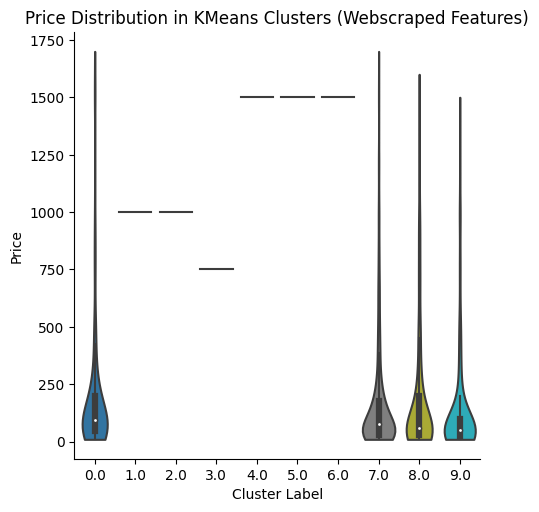

In [31]:
cluster_df, cluster_centers, cluster_labels = train_cluster(numeric_values[mask], target, 10)
cluster_price_df = pd.DataFrame(data = [cluster_labels, target], index = ["Cluster Label", "Price"]).T

sns.catplot(data = cluster_price_df, y="Price", x="Cluster Label",
    kind="violin", bw_adjust=.5, cut=0, split=True,)
plt.title("Price Distribution in KMeans Clusters (Webscraped Features)")

Text(0.5, 1.0, 'Price Distribution in KMeans Clusters (Image Features)')

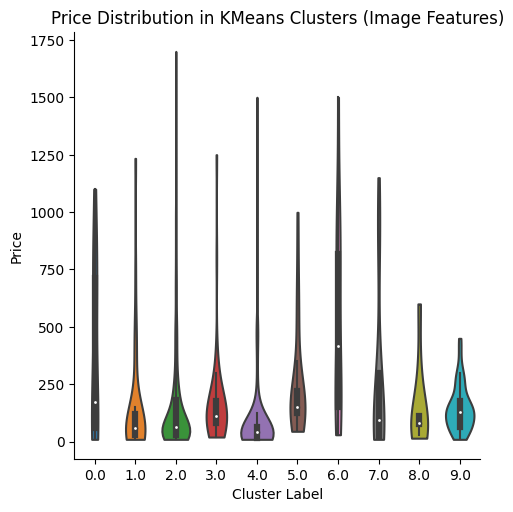

In [32]:
cluster_df, cluster_centers, cluster_labels = train_cluster(image_features[mask], target, 10)
cluster_price_df = pd.DataFrame(data = [cluster_labels, target], index = ["Cluster Label", "Price"]).T

sns.catplot(data = cluster_price_df, y="Price", x="Cluster Label",
    kind="violin", bw_adjust=.5, cut=0, split=True,)
plt.title("Price Distribution in KMeans Clusters (Image Features)")

Text(0.5, 1.0, 'Price Distribution in KMeans Clusters (Text Features)')

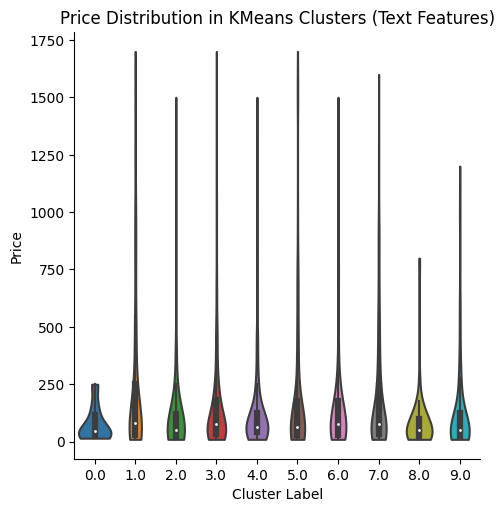

In [33]:
cluster_df, cluster_centers, cluster_labels = train_cluster(text_features[mask], target, 10)
cluster_price_df = pd.DataFrame(data = [cluster_labels, target], index = ["Cluster Label", "Price"]).T

sns.catplot(data = cluster_price_df, y="Price", x="Cluster Label",
    kind="violin", bw_adjust=.5, cut=0, split=True,)
plt.title("Price Distribution in KMeans Clusters (Text Features)")